## Goal:

[MAGIC](https://www.cell.com/action/showPdf?pii=S0092-8674%2818%2930724-4) provides a cool & fast way of denoising data, especially for rare words/genes, by borrowing information across cells. It may help my task ([challenge](https://zihao12.github.io/pyJSMF-RAW/issues_finding_anchor_word)) here, in two ways below:

## Notation

* $X_{ij}$ gene $j$ in cell $i$
* $Y = X^T$ so $Y_{ij}$ gene $i$ in cell $j$

### Apply MAGIC TO $X$
Denoising, particularly for rare genes. Hope is by borrowing info from similar cells, we can get better vector for rare genes

### Apply MAGIC to $Y = X^T$
Not standard usage. We hope to achieve shrinkage. We form a similarity measure between genes, and use this to form a transition matrix, then multiply to  shrink the original matrix (though it seems the transition matrix ia what we want)

### Why MAGIC to $Y = X^T$ works?

* First we construct affinity matrix $D$ for genes, then scale it into transition matrix $M$, then get imputed matrix $Y^{\text{impute}} = M^t Y$ or $Y^{\text{impute}}_{ij} = \sum_k (M^t)_{ik} Y_{kj}$: imputation for gene $i$ in cell $j$ is weighted average of genes in that same cell; the weights are the transition probability from gene $i$ to gene $k$ in $t$ steps.

* The vector for rarer genes are shorter and have wider-ranging angles (more likely to appear extreme). However, our affinity matrix will group those shorter vectors as neighbors, and imputation becomes averaging over those shorter vectors, effectively shrinking them towards the center. 

* Problem is noise may lead to bad affinity matrix, and thus leads to over-shrinkage. For example, a true anchor word is also rather rare, then affinity matrix will decide its neighbors are those short and noisy vectors. Then imputation on this anchor word will smooth out true information. 

* Power parameter $t$ plays a big role here; also the strategy for choosing adaptive gaussian kernel width (in forming affinity matrix) for each gene might be tweaked. 


### Note:
* Seems algorithm is not deterministic. For example, sometimes applied to $X$ finds anchor words; sometimes misses one

In [1]:
import os
import sys
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import numpy as np
import time
import pickle
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

from scipy.stats import betabinom
from scipy.optimize import minimize
import magic
import scprep


script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions4 import *
from misc import *
from sinkhorn import * 

datadir = "../../../gdrive/github_data/pyJSMF-RAW-data"
# %matplotlib widget

np.random.seed(123)

In [2]:
%%capture

## load data
dataname = "sla"
k = 6
rate=3

datafile=f"{datadir}/fit_sim_{dataname}_fastTopics_k{k}_rate{rate}.pkl"
with open(datafile, "rb") as f:
    fitted = pickle.load(f)
    

X = fitted['X']
Ltrue = fitted['Ltrue']
Ftrue = fitted['Ftrue']
n, p = X.shape


Pi_true = Ltrue @ Ftrue.T


# truth
Ctrue = Pi_true.T @ Pi_true / n
Cbar0 = Ctrue / Ctrue.sum(axis = 1)[:, None]


S0, _, _ = findS(Cbar0, k)
Cbar0_pj = pca_proj(Cbar0)


## MAGIC on $X$

In [3]:
X_normalized = scprep.normalize.library_size_normalize(X)
X_normalized = scprep.transform.sqrt(X_normalized)
magic_op = magic.MAGIC()
magic_op.fit(X_normalized)
X_magic = magic_op.transform(X)

Running MAGIC on 3207 cells and 8766 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 0.63 seconds.
  Calculating KNN search...
  Calculated KNN search in 1.11 seconds.
  Calculating affinities...
  Calculated affinities in 1.08 seconds.
Calculated graph and diffusion operator in 2.83 seconds.
Running MAGIC with `solver='exact'` on 8766-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
Calculating imputation...


/home/zihao/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 2.09 seconds.


[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.2416 seconds

[5971 5592 7218  455 3591  959]
[4. 3. 1. 3. 1. 3.]
[ 215. 1671.  421.  461.  520. 1023.]
recoverS with Cbar1


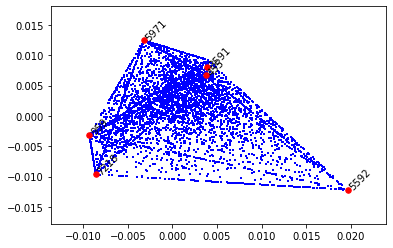

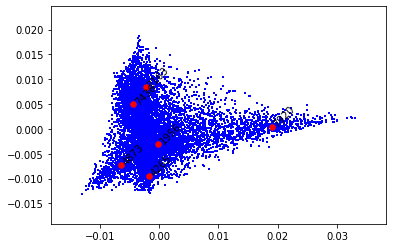

In [4]:
Cbar_m = X_magic / X_magic.sum(axis = 1)[:, None]
Cbar_m = Cbar_m.T @ Cbar_m / n
Cbar_m = Cbar_m / Cbar_m.sum(axis = 1)[:, None] 
S_m, _, _ = findS(Cbar_m, k)
Cbar_m = Cbar_proj(Cbar_m)

print(S_m)
print(X.toarray().sum(axis = 0)[S_m])
print(X.toarray().sum(axis = 0)[S0])

which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_m, S0, which_dim = which_dim, annotate=True,fontsize=10)


### Comment

Algo still picks rare words, but they are closer to true anchor words (except for one)... as MAGIC makes even the rare words contain enough information

## MAGIC  on $X^T$

In [5]:
Y_normalized = scprep.normalize.library_size_normalize(X.T) ## normalizing each gene; could amplify noise
Y_normalized = scprep.transform.sqrt(Y_normalized)
magic_op = magic.MAGIC()
magic_op.fit(Y_normalized)
Y_magic = magic_op.transform(X.T)

Running MAGIC on 8766 cells and 3207 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 0.59 seconds.
  Calculating KNN search...
  Calculated KNN search in 10.54 seconds.
  Calculating affinities...
  Calculated affinities in 10.96 seconds.
Calculated graph and diffusion operator in 22.10 seconds.
Calculating imputation...


/home/zihao/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 2.01 seconds.


[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.2137 seconds

[8694 7914 4892 5677 7071 8659]
[ 253. 2723.  224.  355. 2101.  184.]
[ 215. 1671.  421.  461.  520. 1023.]
recoverS with Cbar1


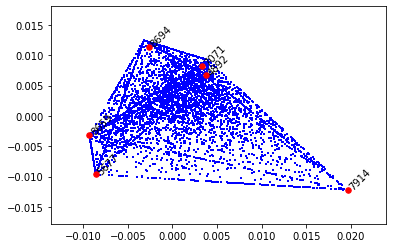

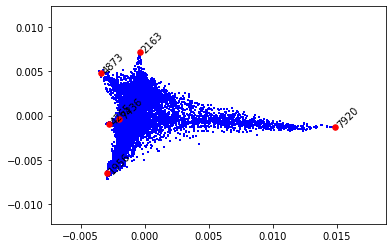

In [6]:
Cbar_m = Y_magic.T / Y_magic.T.sum(axis = 1)[:, None]
Cbar_m = Cbar_m.T @ Cbar_m / n
Cbar_m = Cbar_m / Cbar_m.sum(axis = 1)[:, None] 
S_m, _, _ = findS(Cbar_m, k)
Cbar_m = Cbar_proj(Cbar_m)


print(S_m)
print(X.toarray().sum(axis = 0)[S_m])
print(X.toarray().sum(axis = 0)[S0])


which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_m, S0, which_dim = which_dim, annotate=True,fontsize=10)


### Comment:

* We find great anchor words!
* The shrinkage reveals the anchor words very well. Not sure if it's too aggressive
* There are tuning parameters we can play with (likle $t$)

### Try different $t$

* Use small $t$: less shrinkage/average across genes, compared to large $t$


In [7]:
magic_op = magic.MAGIC()
magic_op.set_params(t = 1)
magic_op.fit(Y_normalized)
Y_magic_t1 = magic_op.transform(X.T)

Running MAGIC on 8766 cells and 3207 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 0.63 seconds.
  Calculating KNN search...
  Calculated KNN search in 9.87 seconds.
  Calculating affinities...
  Calculated affinities in 11.59 seconds.
Calculated graph and diffusion operator in 22.11 seconds.
Calculating imputation...


/home/zihao/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 0.60 seconds.


[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.2081 seconds

[8109 7442 6023 1860 3416 7100]
[ 21.   8.  10.  12. 378.   7.]
[ 215. 1671.  421.  461.  520. 1023.]
recoverS with Cbar1


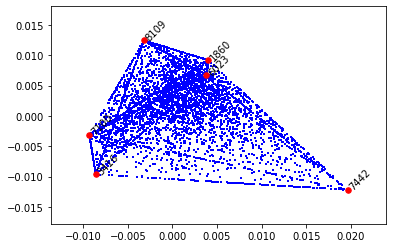

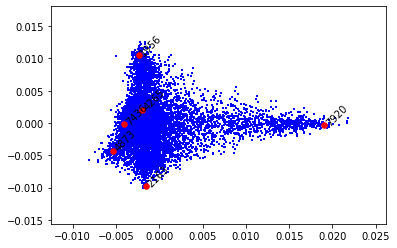

In [8]:
Cbar_m = Y_magic_t1.T / Y_magic_t1.T.sum(axis = 1)[:, None]
Cbar_m = Cbar_m.T @ Cbar_m / n
Cbar_m = Cbar_m / Cbar_m.sum(axis = 1)[:, None] 
S_m, _, _ = findS(Cbar_m, k)
Cbar_m = Cbar_proj(Cbar_m)


print(S_m)
print(X.toarray().sum(axis = 0)[S_m])
print(X.toarray().sum(axis = 0)[S0])


which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_m, S0, which_dim = which_dim, annotate=True,fontsize=10)


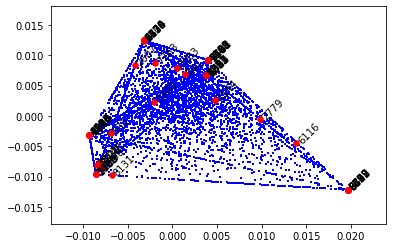

[  10.   14.   28.   11.    8.   16.   14.   25.    6.   21.    6.    8.
   20.    7.   10.    8.    8.    7.    4.    8.    7.    6.    6.    3.
   15.   13.   16.    9.   11.   10.   17.   22.   18.   30.    7.   11.
    7.   19.   10.   12.  403.  461.  430.  391.  437.  428. 1290.  359.
  312.  378.    7.    4.    4.    6.    4.   15.   20.   14.    3.    7.]
{2163}


In [9]:
weights = magic_op.diff_op[S_m,:].toarray()
nbh = []
for i in range(len(S_m)):
    nbh += np.argsort(weights[i,:])[-10:].tolist()
    
vis_extremal_pca(Cbar0_pj, nbh, which_dim = which_dim, annotate=True,fontsize=10)
print(X.toarray().sum(axis = 0)[nbh])
print(set(S0).intersection(set(nbh)))

### Try using diffusion matrix to find anchor words

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.3700 seconds

[2312 4106 7248 2547  382 2693]
[8. 4. 2. 4. 2. 9.]
[ 215. 1671.  421.  461.  520. 1023.]
recoverS with Cbar1


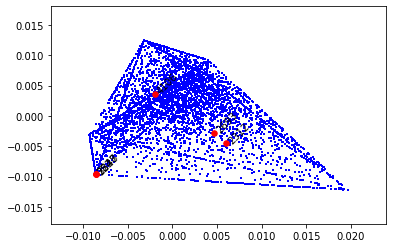

In [10]:
S_m, _, _ = findS(magic_op.diff_op.toarray(), k)


print(S_m)
print(X.toarray().sum(axis = 0)[S_m])
print(X.toarray().sum(axis = 0)[S0])


which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)


### scaling of $X.T$ before computing distance

Previous experiment we scaled each gene to have the same total expression, take sqrt, then PCA to compute distance

In [11]:
Y_normalized = scprep.transform.sqrt(X.T)
magic_op = magic.MAGIC()
magic_op.fit(Y_normalized)
Y_magic = magic_op.transform(X.T)

Running MAGIC on 8766 cells and 3207 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 0.59 seconds.
  Calculating KNN search...
  Calculated KNN search in 8.74 seconds.
  Calculating affinities...
  Calculated affinities in 7.98 seconds.
Calculated graph and diffusion operator in 17.33 seconds.
Calculating imputation...


/home/zihao/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 2.04 seconds.


[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.1892 seconds

[6808 7914 4892 4085 4154   26]
[  36. 2723.  224.   29.   19.   19.]
[ 215. 1671.  421.  461.  520. 1023.]
recoverS with Cbar1


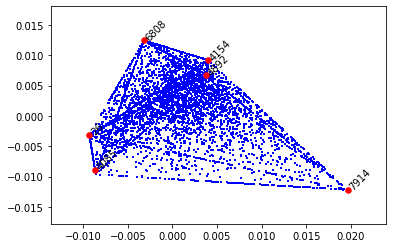

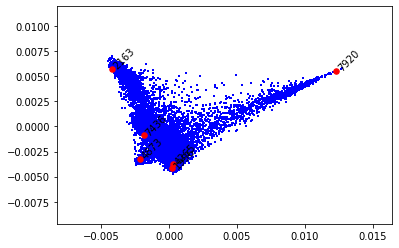

In [12]:
Cbar_m = Y_magic.T / Y_magic.T.sum(axis = 1)[:, None]
Cbar_m = Cbar_m.T @ Cbar_m / n
Cbar_m = Cbar_m / Cbar_m.sum(axis = 1)[:, None] 
S_m, _, _ = findS(Cbar_m, k)
Cbar_m = Cbar_proj(Cbar_m)


print(S_m)
print(X.toarray().sum(axis = 0)[S_m])
print(X.toarray().sum(axis = 0)[S0])


which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_m, S0, which_dim = which_dim, annotate=True,fontsize=10)


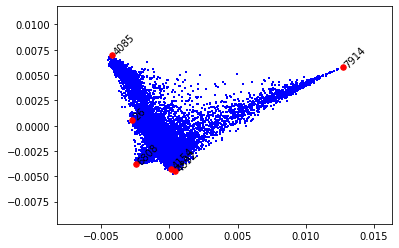

In [13]:
vis_extremal_pca(Cbar_m, S_m, which_dim = which_dim, annotate=True,fontsize=10)
